In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import datetime as dt
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import scipy.stats.mstats as mstats
import statsmodels.api as sm
import pandasql as ps

In [2]:
from scipy.stats import mannwhitneyu as u_test

In [3]:
def multi_u(df,measure,split):
    group = df[split].unique()
#     print(group)
    for i in range(group.shape[0]):
        m1 = df[measure][df[split]==group[i]]
        if i+1 < group.shape[0]:
            m2 = df[measure][df[split]==group[i+1]]
            gr2 = group[i+1]
        else:
            m2 = df[measure][df[split]==group[0]]
            gr2 = group[0]
        u = u_test(m1,m2)
        print(group[i],'vs',gr2,":",u)

In [4]:
def stat(df,group,measure):  
    nor = df.groupby(group)[measure].median()
#     mean = df.groupby(group)[measure].mean()
    nor_lower = df.groupby(group)[measure].quantile(0.25)
    nor_upper = df.groupby(group)[measure].quantile(0.75)
    nor_90 = df.groupby(group)[measure].quantile(0.9)
    nor_10 = df.groupby(group)[measure].quantile(0.1)
    df1 = pd.concat([nor,nor_upper,nor_lower,nor_90,nor_10], axis = 1).fillna(0)
    df1.columns = ['median','q25','q75','q90','q10']
    return df1

In [5]:
def cent_stat(df, group, measure):
    ct = df.groupby(group)[measure].count()
    mean = df.groupby(group)[measure].mean()
    median = df.groupby(group)[measure].median()
    df = pd.concat([ct,mean,median],axis = 1)
    df.columns = ['count','mean','median']
    return df

def dens(measure, bin_range):
    bins = int(np.ceil(measure.max()/bin_range))
    total = len(measure)
    prob = []
    for i in range(bins):
        k = len(measure[(measure >=bin_range*i)&(measure<bin_range*(i+1))])/total
        prob.append(k)
    return prob

In [6]:
lst1 = pd.read_csv(r'./DATA/listing_consumption_oct_till_dec.csv')

In [7]:
lst1.head(2)

,begin_date,duration_actual,end_date,product_id,consumption,accrual,vip_type,enlarged,boosted_or_not,count_boosted_listings,first_boost_date_rank,boost_accrual,boost_consumption,user_id,user_group,parent_category,category_name,province,user_usage,user_time
0,2021-12-26,7,2022-01-02,31995369,19.089,19.089,Normal Listing,No,Not Boosted,NaN,NaN,NaN,NaN,631411,Individual,Nhà đất bán,Bán nhà mặt phố,Cần Thơ,Power,Old User
1,2021-12-26,30,2022-01-25,31993308,81.810,0.000,Normal Listing,No,Not Boosted,NaN,NaN,NaN,NaN,11013,Business,Nhà đất bán,Bán đất,Bà Rịa Vũng Tàu,Power,Old User


In [8]:
lst1['begin_date'] = pd.to_datetime(lst1['begin_date'], yearfirst = True).dt.date

In [9]:
lst2 = pd.read_csv(r'./DATA/listing_consumption_dec_till_jan.csv')

In [10]:
lst0 = pd.concat([lst1[lst1['begin_date'] < dt.date(2021,12,1)], lst2])

In [11]:
lst = lst0[lst0['parent_category']=='Nhà đất bán']

In [12]:
# lst=lst0.copy()

In [13]:
lst['begin_date'] = pd.to_datetime(lst['begin_date'], yearfirst = True)
lst['week']= lst['begin_date'].dt.strftime('%Y-%W').apply(lambda x: dt.datetime.strptime(x + '-1', "%Y-%W-%w"), 1)

In [14]:
lst.head()

,begin_date,duration_actual,end_date,product_id,consumption,accrual,vip_type,enlarged,boosted_or_not,count_boosted_listings,...,boost_accrual,boost_consumption,user_id,user_group,parent_category,category_name,province,user_usage,user_time,week
848981,2021-11-30,7,2021-12-07,31645020,38.178,38.178,Normal Listing,Yes,Boosted,1.0,...,5.454,5.454,1624447,Individual,Nhà đất bán,Bán căn hộ chung cư,Hồ Chí Minh,Power,Old User,2021-11-29
848982,2021-11-30,7,2021-12-07,31397648,19.089,19.089,Normal Listing,No,Not Boosted,NaN,...,NaN,NaN,1693934,Business,Nhà đất bán,Bán nhà mặt phố,Hà Nội,Frequent,Old User,2021-11-29
848984,2021-11-30,7,2021-12-07,31420876,19.089,0.000,Normal Listing,No,Not Boosted,NaN,...,NaN,NaN,1344036,Business,Nhà đất bán,Bán căn hộ chung cư,Hồ Chí Minh,Power,Old User,2021-11-29
848985,2021-11-30,7,2021-12-07,31641646,38.178,0.000,Normal Listing,Yes,Not Boosted,NaN,...,NaN,NaN,1663249,Business,Nhà đất bán,"Bán nhà biệt thự, liền kề",Hà Nội,Power,Old User,2021-11-29
848986,2021-11-30,7,2021-12-07,31640964,350.000,0.000,VIP 3,No,Not Boosted,NaN,...,NaN,NaN,693825,Individual,Nhà đất bán,Bán căn hộ chung cư,Hà Nội,Power,Old User,2021-11-29


In [15]:
lst['begin_date'] = pd.to_datetime(lst['begin_date'], yearfirst = True).dt.date
# lst['period'] = 'v1'
# lst['period'][lst['begin_date'] >= dt.date(2021,11,15)] = 'cool_down'
# lst['period'][lst['begin_date'] >= dt.date(2021,12,1)] = 'v2'

In [16]:
lst.begin_date.max()

datetime.date(2022, 2, 9)

In [17]:
lst.head(3)

,begin_date,duration_actual,end_date,product_id,consumption,accrual,vip_type,enlarged,boosted_or_not,count_boosted_listings,...,boost_accrual,boost_consumption,user_id,user_group,parent_category,category_name,province,user_usage,user_time,week
848981,2021-11-30,7,2021-12-07,31645020,38.178,38.178,Normal Listing,Yes,Boosted,1.0,...,5.454,5.454,1624447,Individual,Nhà đất bán,Bán căn hộ chung cư,Hồ Chí Minh,Power,Old User,2021-11-29
848982,2021-11-30,7,2021-12-07,31397648,19.089,19.089,Normal Listing,No,Not Boosted,NaN,...,NaN,NaN,1693934,Business,Nhà đất bán,Bán nhà mặt phố,Hà Nội,Frequent,Old User,2021-11-29
848984,2021-11-30,7,2021-12-07,31420876,19.089,0.000,Normal Listing,No,Not Boosted,NaN,...,NaN,NaN,1344036,Business,Nhà đất bán,Bán căn hộ chung cư,Hồ Chí Minh,Power,Old User,2021-11-29


In [18]:
lst2 = lst[(lst['begin_date'] >= dt.date(2021,10,4))]

In [19]:
lst1 = lst2.groupby(['week','province','user_id','user_group','user_usage'])[['consumption']].sum()

In [20]:
# lst11 = lst2.groupby(['province','user_id','period','user_group','user_usage','old_boost_version'])[['begin_date']].nunique()
# lst1 = pd.concat([lst10,lst11], axis = 1)

In [21]:
lst1.reset_index(inplace = True)

In [22]:
# lst2.head()

In [23]:
boost = pd.read_csv(r'./DATA/boost_listing_consumption_oct_till_jan.csv')

In [24]:
boost1 = boost[boost['up_date'].isnull()==False]

In [25]:
boost1['up_date'] = pd.to_datetime(boost1['up_date'], yearfirst = True)
boost1['week']= boost1['up_date'].dt.strftime('%Y-%W').apply(lambda x: dt.datetime.strptime(x + '-1', "%Y-%W-%w"), 1)

In [26]:
boost1['up_date'] = pd.to_datetime(boost1['up_date'], yearfirst = True).dt.date
# boost1['period'] = 'v1'
# boost1['period'][boost1['up_date'] >= dt.date(2021,11,15)] = 'cool_down'
# boost1['period'][boost1['up_date'] >= dt.date(2021,12,1)] = 'v2'

In [27]:
boost1.head()

,up_date,user_id,consumption_amount,parent_category,province,week
0,2021-09-01,753010,2.727,Nhà đất cho thuê,Hà Nội,2021-08-30
1,2021-09-07,89330,0.000,Nhà đất bán,Hồ Chí Minh,2021-09-06
2,2021-09-14,89330,0.000,Nhà đất bán,Hồ Chí Minh,2021-09-13
3,2021-09-21,89330,0.000,Nhà đất bán,Hồ Chí Minh,2021-09-20
4,2021-09-28,89330,0.000,Nhà đất bán,Hồ Chí Minh,2021-09-27


In [28]:
boost1.columns = ['up_date', 'user_id', 'boost_consumption', 'parent_category',
       'province', 'week']

In [29]:
boost2 = boost1[(boost1.up_date >= dt.date(2021,10,4))
               &(boost1['parent_category']=='Nhà đất bán')].groupby(['week','user_id','province'])[['boost_consumption']].sum()

In [30]:
boost2.head(2)

boost_consumption
week       user_id province                      
2021-10-04 387     Hà Nội                   2.727
           393     Hồ Chí Minh              5.454

In [31]:
lst_u = lst1.merge(boost2, how = 'left', left_on = ['week','user_id','province'],right_index = True).fillna(0)
lst_u['total_consumption'] = lst_u['consumption'] + lst_u['boost_consumption']

In [32]:
lst_u['old_boost_version'] = "7 day"
lst_u['old_boost_version'][(np.remainder(lst_u.user_id,10) < 4)&(np.remainder(lst_u.user_id,10) >= 2)] = '3 day'
lst_u['old_boost_version'][np.remainder(lst_u.user_id,10) < 2] = '5 day'

In [33]:
lst_u['week'] = pd.to_datetime(lst_u['week'], yearfirst = True).dt.date

In [34]:
lst_u['period'] = 'v1'
lst_u['period'][lst_u['week'] >= dt.date(2021,11,15)] = 'cool_down'
lst_u['period'][lst_u['week'] >= dt.date(2021,11,29)] = 'v2'
lst_u['period'][lst_u['week'] >= dt.date(2022,1,1)] = 'cool_down_2'

In [35]:
# lst_u = lst_u[lst_u['period'] != 'cool_down_2']

In [36]:
lst_u.week.min()

datetime.date(2021, 10, 4)

In [37]:
sns.set(rc={'figure.figsize':(15,5)})

In [38]:
lst_u['consumption_w'] = mstats.winsorize(lst_u['total_consumption'], limits=[0.00, 0.01])

In [39]:
prov_week = lst_u.groupby(['week','province'])[['consumption_w']].mean()

In [40]:
pr = prov_week.unstack(level = 1)

In [41]:
pr.columns = pr.columns.get_level_values(1)

In [ ]:
# y = prov_week['week']
plt.plot(pr['Hồ Chí Minh'], 'go-', label = 'Hồ Chí Minh')
plt.plot(pr['Đồng Nai'], color='purple', label = 'Đồng Nai')
plt.plot(pr['Bà Rịa Vũng Tàu'], color='navy', label = 'Vũng Tàu')
# plt.plot(pr['Đà Nẵng'], 'y--', label = 'Đà Nẵng')
# plt.plot(pr['Khánh Hòa'], 'b--', label = 'Khánh Hòa')
plt.legend()

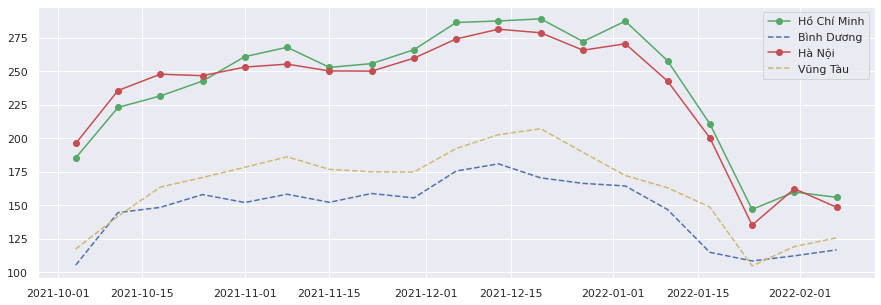

In [48]:
# y = prov_week['week']
plt.plot(pr['Hồ Chí Minh'], 'go-', label = 'Hồ Chí Minh')
plt.plot(pr['Bình Dương'], 'b--', label = 'Bình Dương')
plt.plot(pr['Hà Nội'], 'ro-', label = 'Hà Nội')
# plt.plot(pr['Đồng Nai'], color='purple', label = 'Đồng Nai')
plt.plot(pr['Bà Rịa Vũng Tàu'], 'y--', label = 'Vũng Tàu')
# plt.plot(pr['Đà Nẵng'], 'y--', label = 'Đà Nẵng')
# plt.plot(pr['Khánh Hòa'], 'b--', label = 'Khánh Hòa')
plt.legend()

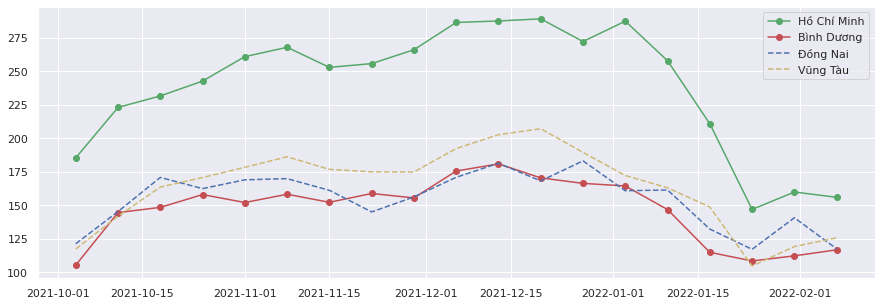

In [54]:
# y = prov_week['week']
plt.plot(pr['Hồ Chí Minh'], 'go-', label = 'Hồ Chí Minh')
plt.plot(pr['Bình Dương'], 'ro-', label = 'Bình Dương')
# plt.plot(pr['Hà Nội'], 'ro-', label = 'Hà Nội')
plt.plot(pr['Đồng Nai'], 'b--', label = 'Đồng Nai')
plt.plot(pr['Bà Rịa Vũng Tàu'], 'y--', label = 'Vũng Tàu')
plt.legend()

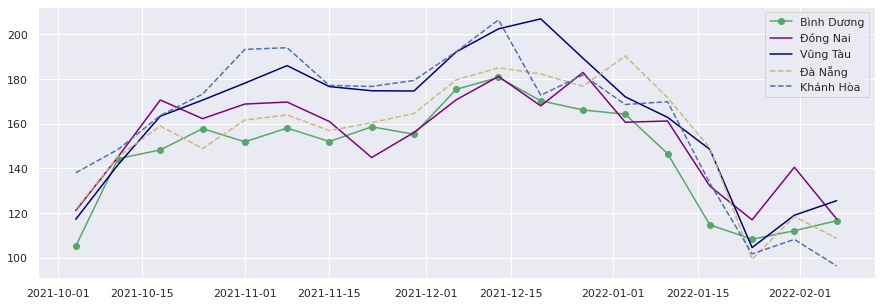

In [43]:
plt.plot(pr['Bình Dương'], 'go-', label = 'Bình Dương')
plt.plot(pr['Đồng Nai'], color='purple', label = 'Đồng Nai')
plt.plot(pr['Bà Rịa Vũng Tàu'], color='navy', label = 'Vũng Tàu')
# plt.plot(pr['Cần Thơ'], color='violet', label = 'Cần Thơ')
plt.plot(pr['Đà Nẵng'], 'y--', label = 'Đà Nẵng')
plt.plot(pr['Khánh Hòa'], 'b--', label = 'Khánh Hòa')
plt.legend()

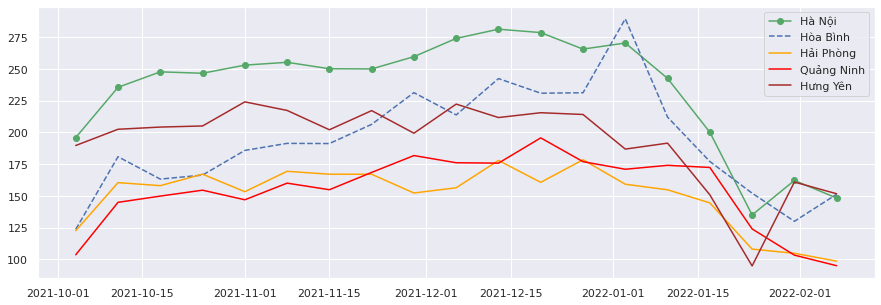

In [44]:
plt.plot(pr['Hà Nội'], 'go-', label = 'Hà Nội')
plt.plot(pr['Hòa Bình'], 'b--', label = 'Hòa Bình')
plt.plot(pr['Hải Phòng'], color='orange', label = 'Hải Phòng')
plt.plot(pr['Quảng Ninh'], color='red', label = 'Quảng Ninh')
plt.plot(pr['Hưng Yên'], color='brown', label = 'Hưng Yên')
# plt.plot(pr['Đà Nẵng'], 'y--', label = 'Đà Nẵng')
# plt.plot(pr['Khánh Hòa'], 'b--', label = 'Khánh Hòa')
plt.legend()

In [288]:
stat(lst_u,group=['week','province'], measure =['total_consumption'])

median        q25     q75       q90      q10
week       province                                                      
2021-10-04 An Giang         19.0890   38.17800   0.000  141.2586   0.0000
           Bà Rịa Vũng Tàu  38.1780  112.01150  19.089  281.6991   0.0000
           Bình Dương       38.1780   84.53700  19.089  235.8085   0.0000
           Bình Phước       57.2670  168.32250  19.089  293.4252  14.1804
           Bình Thuận       47.4500  130.89600  19.089  499.9952   0.0000
...                             ...        ...     ...       ...      ...
2022-01-10 Đà Nẵng          75.4015  171.80100  27.270  419.9580  19.0890
           Đắk Lắk          27.2700   54.54000  19.089   95.4450  19.0890
           Đắk Nông         37.2235  113.10225  19.089  413.6300  19.0890
           Đồng Nai         57.2670  152.71200  27.270  414.2493  19.0890
           Đồng Tháp        57.2670  350.00000  27.270  350.0000  19.0890

[927 rows x 5 columns]

In [289]:
# lst_u2 = lst_u[lst_u['week'] >= dt.date(2021, 11, 1)]
lst_u2 = lst_u.copy()

In [290]:
bd_u = lst_u2[lst_u2['province'] == "Bình Dương"]
hcm_u = lst_u2[lst_u2['province'] == "Hồ Chí Minh"]
hn_u = lst_u2[lst_u2['province'] == "Hà Nội"]
dn_u = lst_u2[lst_u2['province'] == "Đồng Nai"]
la_u = lst_u2[lst_u2['province'] == "Long An"]
hb_u = lst_u2[lst_u2['province'] == "Hòa Bình"]
hp_u = lst_u2[lst_u2['province'] == "Hải Phòng"]
vt_u = lst_u2[lst_u2['province'] == "Bà Rịa Vũng Tàu"]
dna_u = lst_u2[lst_u2['province'] == "Đà Nẵng"]

In [291]:
def multi_u(df,measure,split):
    group = df[split].unique()
#     print(group)
    for i in range(group.shape[0]):
        m1 = df[measure][df[split]==group[i]]
        if i+1 < group.shape[0]:
            m2 = df[measure][df[split]==group[i+1]]
            gr2 = group[i+1]
        else:
            m2 = df[measure][df[split]==group[0]]
            gr2 = group[0]
        u = u_test(m1,m2)
        print(group[i],'vs',gr2,":",u)

In [292]:
def density_plot(df, measure = 'consumption_w',split = 'period', money_range = 100):
    group = df[split].unique()
    for i in range(group.shape[0]):
        x = dens(df[measure][df[split]==group[i]], bin_range = money_range)
        y = list(range(1, len(x)+1))
        plt.plot(y, x, label = group[i])
        
    plt.legend()
    plt.show()

#  Xem có sự khác biệt giữa các nhóm người dùng đã được tham gia Boost từ trước và nhóm ko được ko

In [293]:
lst.columns

Index(['begin_date', 'duration_actual', 'end_date', 'product_id',
       'consumption', 'accrual', 'vip_type', 'enlarged', 'boosted_or_not',
       'count_boosted_listings', 'first_boost_date_rank', 'boost_accrual',
       'boost_consumption', 'user_id', 'user_group', 'parent_category',
       'category_name', 'province', 'user_usage', 'user_time', 'week',
       'is_vip', 'total_consumption'],
      dtype='object')

In [296]:
user = lst_u.groupby(['user_id','user_group','user_usage','old_boost_version'])[['total_consumption']].sum()

In [297]:
user.reset_index(inplace = True)

In [298]:
multi_u(user,'total_consumption','old_boost_version')

5 day vs 7 day : MannwhitneyuResult(statistic=521134700.5, pvalue=0.09792655980064835)
7 day vs 3 day : MannwhitneyuResult(statistic=522432404.0, pvalue=0.13762857182793747)
3 day vs 5 day : MannwhitneyuResult(statistic=175803337.5, pvalue=0.4373382953051822)


In [300]:
user_prov = lst_u.groupby(['user_id','user_group','user_usage','old_boost_version','province'])[['total_consumption']].sum()
user_prov.reset_index(inplace = True)

In [301]:
lst_u.head()

,week,province,user_id,user_group,user_usage,consumption,boost_consumption,total_consumption,old_boost_version,period,consumption_w
0,2021-10-04,An Giang,141400,Individual,Frequent,169.074,0.0,169.074,5 day,v1,169.074
1,2021-10-04,An Giang,307635,Individual,Frequent,545.454,0.0,545.454,7 day,v1,545.454
2,2021-10-04,An Giang,348114,Individual,Power,38.178,0.0,38.178,7 day,v1,38.178
3,2021-10-04,An Giang,571973,Individual,Power,19.089,0.0,19.089,3 day,v1,19.089
4,2021-10-04,An Giang,829520,Individual,Frequent,0.000,0.0,0.000,5 day,v1,0.000


In [303]:
user_prov_v2 = lst_u[lst_u['week'] >= dt.date(2021,11,15)].groupby(['user_id','user_group','user_usage','old_boost_version','province'])[['total_consumption']].sum()
user_prov_v2.reset_index(inplace = True)

In [305]:
user_b = lst_u[lst_u['week'] >= dt.date(2021,11,15)].groupby(['user_id','user_group','user_usage','old_boost_version'])[['boost_consumption','total_consumption']].sum()

In [306]:
user_b['boost_perc'] = user_b['boost_consumption']/user_b['total_consumption']*100

In [307]:
user_b.reset_index(inplace = True)

In [308]:
multi_u(user_b,'boost_perc','old_boost_version')

7 day vs 3 day : MannwhitneyuResult(statistic=325490913.5, pvalue=0.3525743060131168)
3 day vs 5 day : MannwhitneyuResult(statistic=108125513.0, pvalue=0.18565646734403385)
5 day vs 7 day : MannwhitneyuResult(statistic=323111596.0, pvalue=0.23667152952475423)


In [62]:
# user_prov_v2_b = lst_u[lst_u['week'] >= dt.date(2021,11,15)].groupby(['user_id','user_group','user_time','user_usage','old_boost_version','province'])[['boost_consumption','total_consumption']].sum()
# user_prov_v2_b.reset_index(inplace = True)

### Tại Hà Nội

In [309]:
hn = user_prov_v2[user_prov_v2['province']=='Hà Nội']

In [310]:
multi_u(hn,'total_consumption','old_boost_version')

7 day vs 3 day : MannwhitneyuResult(statistic=34952072.5, pvalue=0.3409747083178357)
3 day vs 5 day : MannwhitneyuResult(statistic=11367305.5, pvalue=0.19758627046125737)
5 day vs 7 day : MannwhitneyuResult(statistic=34060282.5, pvalue=0.2612346900573186)


In [311]:
multi_u(hn_u[hn_u['period']!='v1'],'total_consumption','old_boost_version')

7 day vs 3 day : MannwhitneyuResult(statistic=488884336.5, pvalue=0.27432701108441204)
3 day vs 5 day : MannwhitneyuResult(statistic=161744141.0, pvalue=0.266104435399317)
5 day vs 7 day : MannwhitneyuResult(statistic=482886782.0, pvalue=0.44234651997062663)


In [66]:
# hn_agent = hn_u[hn_u['user_usage']!='Casual']

In [67]:
# multi_u(hn_agent[hn_agent['period']!='v1'],'total_consumption','old_boost_version')

In [68]:
# ax = sns.boxplot(x="old_boost_version", y="consumption_w", data=hn_u[hn_u['period']=='v1'].sort_values(by='old_boost_version'),showfliers = False)

In [69]:
# hn_u[hn_u['period']=='v2'].groupby(['old_boost_version'])['consumption_w'].describe()

In [70]:
# density_plot(hn_u[hn_u['period']=='v1'], split = 'old_boost_version', money_range = 100)

### Tại HCM

In [312]:
hcm = user_prov_v2[user_prov_v2['province']=='Hồ Chí Minh']

In [313]:
u_test(hcm['total_consumption'][(hcm['old_boost_version']=='7 day')],
      hcm['total_consumption'][(hcm['old_boost_version']!='7 day')])

MannwhitneyuResult(statistic=45969950.0, pvalue=0.34879042740221)

Test thử với riêng Power User: Kết quả vẫn là không significant

In [73]:
# u_test(hcm_agent['total_consumption'][(hcm_agent['old_boost_version']=='7 day')],
#       hcm_agent['total_consumption'][(hcm_agent['old_boost_version']!='7 day')])

**Tuy nhiên không hiểu sao khi xem dữ liệu consumption theo tuần thì kết quả test lại ra là CÓ KHÁC BIỆT giữa các nhóm người dùng ở version boost cũ**

In [314]:
k = hcm_u.groupby(['user_id','user_group'])['total_consumption'].max()

In [315]:
k.sort_values(ascending = False).head(10)

user_id  user_group
348569   Individual    19542.722
233197   Business      19405.768
746146   Individual    18499.963
555980   Business      15753.463
201783   Individual    14540.925
233855   Business      14330.476
541038   Individual    13802.537
349921   Individual    11809.058
1775702  Individual    11638.178
425823   Business      10874.907
Name: total_consumption, dtype: float64

In [316]:
hcm_agent = hcm[(hcm['user_usage']=='Power')&(hcm['user_id'].isin([]) == False)]

In [317]:
multi_u(hcm_u[hcm_u['period']=='v2'],'total_consumption','old_boost_version')

3 day vs 5 day : MannwhitneyuResult(statistic=31492696.0, pvalue=0.13021887986345876)
5 day vs 7 day : MannwhitneyuResult(statistic=95610554.5, pvalue=0.14300759174083116)
7 day vs 3 day : MannwhitneyuResult(statistic=95356124.0, pvalue=0.007369243028680062)


Có khả năng là do có người dùng cũ mới quay lại gần đây hoặc mới tiêu thêm nhiều gần đây do trend đi lên của thị trường

In [318]:
u_test(hcm_u['total_consumption'][(hcm_u['period']=='v2')&(hcm_u['old_boost_version']=='7 day')],
      hcm_u['total_consumption'][(hcm_u['period']=='v2')&(hcm_u['old_boost_version']!='7 day')])

MannwhitneyuResult(statistic=190966678.5, pvalue=0.013160052259954154)

In [79]:
# density_plot(hcm_u[hcm_u['period']=='v2'], split = 'old_boost_version', money_range = 100)

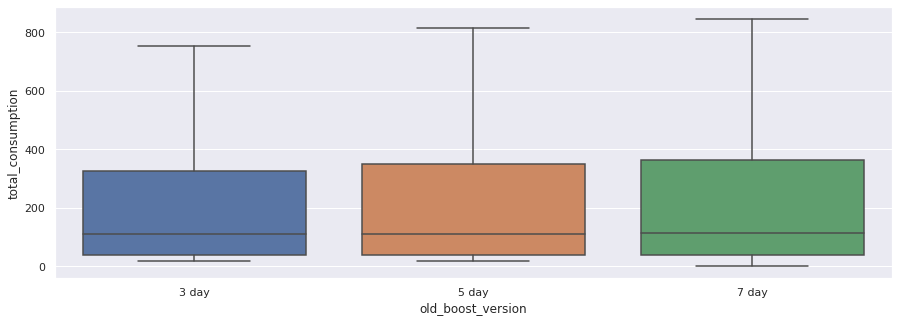

In [319]:
ax = sns.boxplot(x="old_boost_version", y="total_consumption", data=hcm_u[hcm_u['period']=='v2'].sort_values(by='old_boost_version'),showfliers = False)

In [320]:
hcm_u.groupby(['old_boost_version'])['total_consumption'].describe()

,count,mean,std,min,25%,50%,75%,max
old_boost_version,,,,,,,,
3 day,22750.0,264.685221,511.284587,0.0,38.178,95.445,297.8575,14540.925
5 day,22327.0,280.006362,585.599196,0.0,38.178,99.263,313.7275,15753.463
7 day,68493.0,285.075191,552.569071,0.0,38.178,103.626,343.6020,19542.722


### Tại Bình Dương

In [321]:
bd = user_prov_v2[user_prov_v2['province']=='Bình Dương']

In [322]:
multi_u(bd,'total_consumption','old_boost_version')

7 day vs 5 day : MannwhitneyuResult(statistic=1832339.5, pvalue=0.2063002499491527)
5 day vs 3 day : MannwhitneyuResult(statistic=609192.5, pvalue=0.18875639095524227)
3 day vs 7 day : MannwhitneyuResult(statistic=1903833.5, pvalue=0.39785172994928225)


In [323]:
multi_u(bd_u[bd_u['period']=='v2'],'total_consumption','old_boost_version')

5 day vs 3 day : MannwhitneyuResult(statistic=1899656.0, pvalue=0.3963951438162987)
3 day vs 7 day : MannwhitneyuResult(statistic=5972400.5, pvalue=0.20939407027462376)
7 day vs 5 day : MannwhitneyuResult(statistic=5560447.5, pvalue=0.133607865457894)


# So sánh giữa các khu vực trong các khoảng thời gian khác nhau

In [324]:
lst['total_consumption'] = lst['consumption'].fillna(0) + lst['boost_consumption'].fillna(0)

In [325]:
lst.vip_type.unique()

array(['Normal Listing', 'VIP 3', 'VIP Special', 'VIP 1', 'VIP 90 Days',
       'VIP 2'], dtype=object)

In [326]:
lst['is_vip'] = 'vip'
lst['is_vip'][lst.vip_type == 'Normal Listing'] = 'normal'

In [338]:
user_b = lst.groupby(['user_id'])[['boost_consumption','total_consumption']].sum()

In [339]:
user_b.reset_index(inplace = True)

In [340]:
user_b[user_b.user_id == 1707640]

,user_id,boost_consumption,total_consumption
72943,1707640,0.0,21047.258


In [341]:
lst_u_vip = lst[lst.vip_type != 'Normal Listing'].groupby(['user_id'])[['consumption','boost_consumption']].sum()

In [342]:
lst_u_vip['total_vip_consumption'] = lst_u_vip['consumption'] + lst_u_vip['boost_consumption']

In [343]:
lst_u_vip.reset_index(inplace = True)

In [358]:
lst_u_vip[lst_u_vip.user_id == 2096]

,user_id,consumption,boost_consumption,total_vip_consumption


In [345]:
user_b['boost_perc'] = user_b['boost_consumption']/user_b['total_consumption']*100

In [346]:
no_boost = user_b[user_b['boost_perc']==0]

In [347]:
user_b.head()

,user_id,boost_consumption,total_consumption,boost_perc
0,141,0.000,19.089,0.000000
1,159,0.000,104.988,0.000000
2,162,0.000,109.080,0.000000
3,169,16.362,452.682,3.614458
4,198,0.000,38.178,0.000000


In [362]:
lst_u_vip.head()

,user_id,consumption,boost_consumption,total_vip_consumption
0,301,545.454,0.000,545.454
1,382,350.000,0.000,350.000
2,387,15272.712,181.818,15454.530
3,393,1818.180,0.000,1818.180
4,415,350.000,0.000,350.000


In [363]:
ub2 = user_b.merge(lst_u_vip[['user_id','total_vip_consumption']], how = 'left', on = ['user_id']).fillna(0)

In [364]:
ub2 = ub2[ub2['total_consumption']>0]

In [365]:
ub2['vip_percentage'] = ub2['total_vip_consumption']/ub2['total_consumption']*100

In [366]:
ub2.head()

,user_id,boost_consumption,total_consumption,boost_perc,total_vip_consumption,vip_percentage
0,141,0.000,19.089,0.000000,0.0,0.0
1,159,0.000,104.988,0.000000,0.0,0.0
2,162,0.000,109.080,0.000000,0.0,0.0
3,169,16.362,452.682,3.614458,0.0,0.0
4,198,0.000,38.178,0.000000,0.0,0.0


In [367]:
ub2['boost_user'] = "boost"
ub2['boost_user'][ub2['boost_perc']==0] = 'non-boost'

In [368]:
multi_u(ub2,'vip_percentage','boost_user')

non-boost vs boost : MannwhitneyuResult(statistic=893436527.0, pvalue=1.6083580250386525e-104)
boost vs non-boost : MannwhitneyuResult(statistic=893436527.0, pvalue=1.6083580250386525e-104)


In [369]:
ub2.groupby(['boost_user'])['vip_percentage'].describe()

,count,mean,std,min,25%,50%,75%,max
boost_user,,,,,,,,
boost,26788.0,19.148371,31.212523,0.0,0.0,0.0,34.168193,100.0
non-boost,71633.0,18.977957,36.708586,0.0,0.0,0.0,0.000000,100.0


In [371]:
ub2.groupby(['boost_user'])['total_consumption'].describe()

,count,mean,std,min,25%,50%,75%,max
boost_user,,,,,,,,
boost,26788.0,2717.848239,5345.661229,2.727,433.593,1177.396,3052.565,201972.236
non-boost,71633.0,679.395682,3221.740720,14.999,38.178,130.896,591.759,697207.955


In [373]:
# ub2.sort_values(by=['vip_percentage'], ascending = False)

In [90]:
user_b.shape[0]

95779

In [375]:
no_boost['user_id']

0            141
1            159
2            162
4            198
5            222
          ...   
98535    1782853
98536    1782859
98537    1783040
98538    1783082
98539    1783297
Name: user_id, Length: 71633, dtype: int64

In [378]:
lst_u.head()

,week,province,user_id,user_group,user_usage,consumption,boost_consumption,total_consumption,old_boost_version,period,consumption_w
0,2021-10-04,An Giang,141400,Individual,Frequent,169.074,0.0,169.074,5 day,v1,169.074
1,2021-10-04,An Giang,307635,Individual,Frequent,545.454,0.0,545.454,7 day,v1,545.454
2,2021-10-04,An Giang,348114,Individual,Power,38.178,0.0,38.178,7 day,v1,38.178
3,2021-10-04,An Giang,571973,Individual,Power,19.089,0.0,19.089,3 day,v1,19.089
4,2021-10-04,An Giang,829520,Individual,Frequent,0.000,0.0,0.000,5 day,v1,0.000


In [379]:
nbu = lst_u.merge(no_boost['user_id'], on = 'user_id', how = 'inner')

In [380]:
nbu.head()

,week,province,user_id,user_group,user_usage,consumption,boost_consumption,total_consumption,old_boost_version,period,consumption_w
0,2021-10-04,An Giang,141400,Individual,Frequent,169.074,0.0,169.074,5 day,v1,169.074
1,2021-11-01,An Giang,141400,Individual,Frequent,27.270,0.0,27.270,5 day,v1,27.270
2,2021-12-20,An Giang,141400,Individual,Frequent,27.270,0.0,27.270,5 day,v2,27.270
3,2022-01-10,An Giang,141400,Individual,Frequent,84.537,0.0,84.537,5 day,cool_down_2,84.537
4,2021-10-04,An Giang,307635,Individual,Frequent,545.454,0.0,545.454,7 day,v1,545.454


In [383]:
multi_u(nbu,'total_consumption','period')

v1 vs v2 : MannwhitneyuResult(statistic=3628291634.5, pvalue=1.300420992439351e-54)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=1323386260.5, pvalue=0.37866275657123993)
cool_down_2 vs cool_down : MannwhitneyuResult(statistic=535793500.5, pvalue=0.00021842518174398177)
cool_down vs v1 : MannwhitneyuResult(statistic=1512553836.0, pvalue=1.6497563173040622e-15)


## Hồ Chí Minh

In [91]:
multi_u(hcm_u[hcm_u['user_usage']=="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=2135060.0, pvalue=0.2236926058630161)
cool_down vs v2 : MannwhitneyuResult(statistic=1987888.0, pvalue=0.025144011968917045)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=1078841.5, pvalue=3.911006634061904e-09)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=1112322.5, pvalue=4.211604782670189e-11)


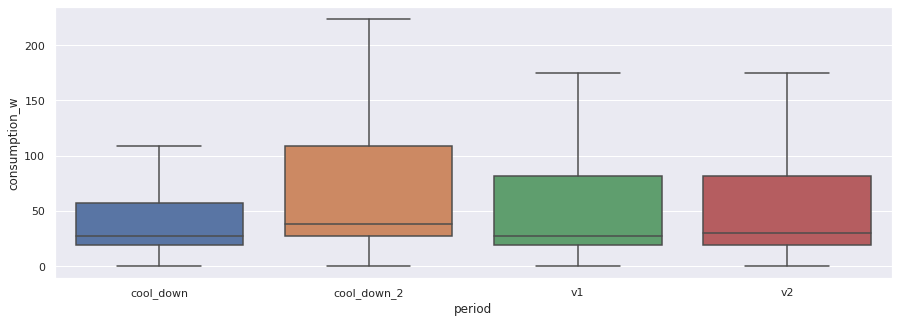

In [92]:
ax = sns.boxplot(x="period", y="consumption_w", data=hcm_u[hcm_u['user_usage']=="Casual"].sort_values(by='period'),showfliers = False)

In [93]:
multi_u(hcm_u[hcm_u['user_usage']!="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=285966923.0, pvalue=3.6280097769637765e-14)
cool_down vs v2 : MannwhitneyuResult(statistic=272820237.0, pvalue=3.281752900418533e-07)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=242630793.5, pvalue=0.00012499847736053776)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=251275866.5, pvalue=3.7043757642964715e-16)


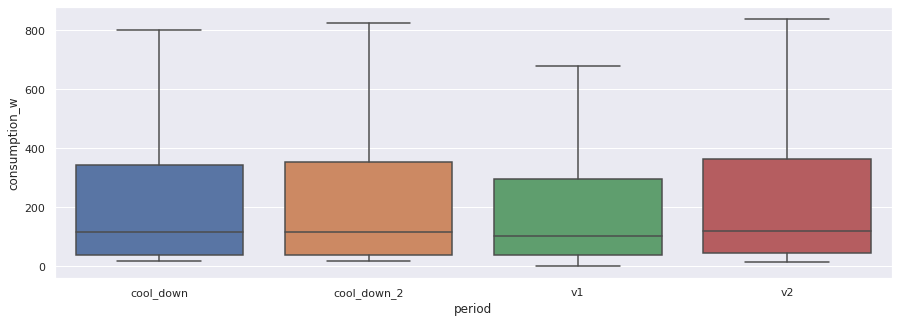

In [94]:
ax = sns.boxplot(x="period", y="consumption_w", data=hcm_u[hcm_u['user_usage']!="Casual"].sort_values(by='period'),showfliers = False)

In [95]:
cent_stat(hcm_u[hcm_u['user_usage']!="Casual"],group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,15080,280.256528,114.534
cool_down_2,13324,301.391421,114.534
v1,39561,262.147028,100.899
v2,37214,315.851435,117.876


In [96]:
multi_u(hcm_u[hcm_u['old_boost_version']=="7 day"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=124800015.5, pvalue=1.0721002128312825e-05)
cool_down vs v2 : MannwhitneyuResult(statistic=117395137.0, pvalue=4.122770684503043e-06)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=102245929.0, pvalue=0.1795090849796468)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=103487625.5, pvalue=1.6219252641204394e-13)


In [97]:
multi_u(hcm_u[hcm_u['old_boost_version']!="7 day"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=52597039.5, pvalue=5.223178569511973e-07)
cool_down vs v2 : MannwhitneyuResult(statistic=50244058.0, pvalue=0.0010547171501245633)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=45121531.5, pvalue=0.3469832109721952)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=45094647.5, pvalue=4.155768708698224e-13)


In [98]:
cent_stat(hcm_u[hcm_u['old_boost_version']=="7 day"],group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,9952,273.872037,100.899
cool_down_2,8459,294.794543,111.807
v1,25827,258.762881,95.445
v2,24337,313.266032,111.807


In [99]:
# ax = sns.boxplot(x="period", y="consumption_w", data=hcm_u[hcm_u['user_usage']=="Power"].sort_values(by='period'),showfliers = False)

## Hà Nội

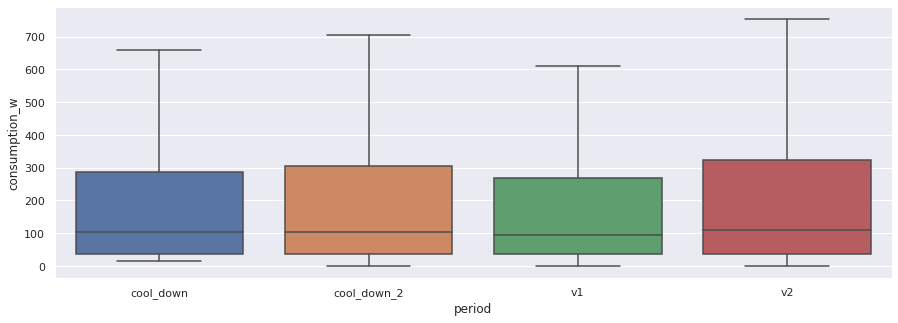

In [100]:
ax = sns.boxplot(x="period", y="consumption_w", data=hn_u.sort_values(by='period'),showfliers = False)

In [101]:
multi_u(hn_u,'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=599433702.0, pvalue=2.758709360282567e-13)
cool_down vs v2 : MannwhitneyuResult(statistic=523467799.0, pvalue=7.256635810022973e-06)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=454630831.5, pvalue=1.0668471225342818e-05)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=521576455.5, pvalue=2.0055248678831372e-11)


In [102]:
cent_stat(hn_u,group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,20623,266.376079,103.626
cool_down_2,17923,281.017338,104.034
v1,60152,256.630030,95.445
v2,51833,294.031007,110.550


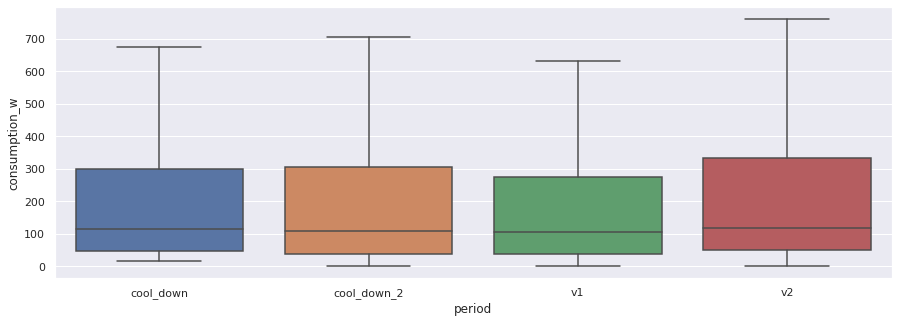

In [103]:
ax = sns.boxplot(x="period", y="consumption_w", data=hn_u[hn_u['user_usage']!="Casual"].sort_values(by='period'),showfliers = False)

In [104]:
multi_u(hn_u[hn_u['user_usage']!="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=518875828.0, pvalue=4.632316138939143e-13)
cool_down vs v2 : MannwhitneyuResult(statistic=445991487.5, pvalue=6.472264642800494e-07)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=385316068.0, pvalue=2.0970494376818093e-16)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=465812093.5, pvalue=0.0012004370936954563)


In [105]:
cent_stat(hn_u[hn_u['user_usage']!="Casual"],group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,19168,273.515809,114.534
cool_down_2,16874,284.410357,109.080
v1,56073,263.231691,105.945
v2,47674,302.929132,117.261


In [106]:
cent_stat(hn_u[hn_u['old_boost_version']=="7 day"],group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,12398,261.079196,103.626
cool_down_2,10677,276.453480,109.080
v1,36380,254.358162,95.445
v2,31133,288.558869,111.672


In [107]:
# cent_stat(hn_u[hn_u['old_boost_version']!="7 day"],group = ['period'], measure = ['total_consumption'])

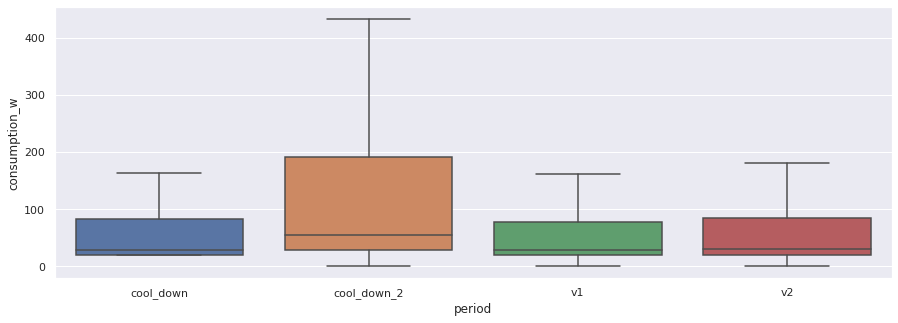

In [108]:
ax = sns.boxplot(x="period", y="consumption_w", data=hn_u[hn_u['user_usage']=="Casual"].sort_values(by='period'),showfliers = False)

In [109]:
multi_u(hn_u[hn_u['user_usage']=="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=2811498.0, pvalue=0.0011793268395741642)
cool_down vs v2 : MannwhitneyuResult(statistic=2902488.0, pvalue=0.009299650583664212)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=1769181.0, pvalue=4.47561881841202e-22)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=1550622.0, pvalue=1.0722031429094368e-44)


In [110]:
# density_plot(hn_u)

## Bình Dương

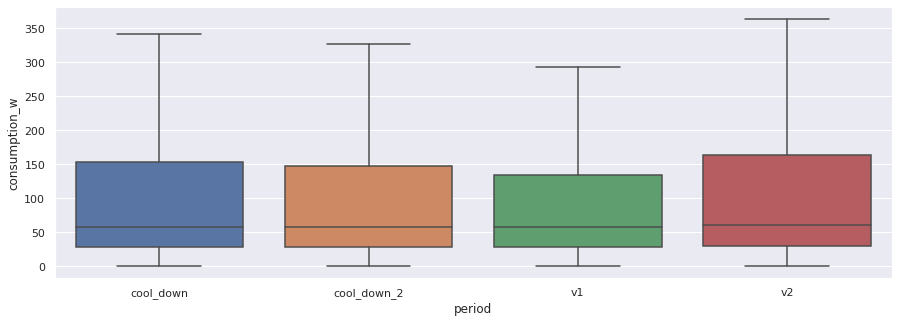

In [111]:
ax = sns.boxplot(x="period", y="consumption_w", data=bd_u[bd_u['user_usage']!="Casual"].sort_values(by='period'),showfliers = False)

In [112]:
multi_u(bd_u[bd_u['user_usage']!="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=15128844.5, pvalue=1.3781015088608359e-05)
cool_down vs v2 : MannwhitneyuResult(statistic=16495888.0, pvalue=0.0028177487145526967)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=12790556.5, pvalue=2.0974751805103985e-07)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=12495702.0, pvalue=0.08220132221603166)


In [113]:
cent_stat(bd_u,group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,4099,161.933728,57.267
cool_down_2,3233,163.979717,57.267
v1,9192,152.293659,54.540
v2,9910,179.549349,57.267


In [114]:
multi_u(bd_u[bd_u['user_usage']=="Casual"],'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=123563.0, pvalue=0.2757757280363463)
cool_down vs v2 : MannwhitneyuResult(statistic=131097.0, pvalue=0.0039316341420997745)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=82399.0, pvalue=0.0006156694054407819)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=65726.0, pvalue=4.752323375316669e-07)


### Vũng Tàu

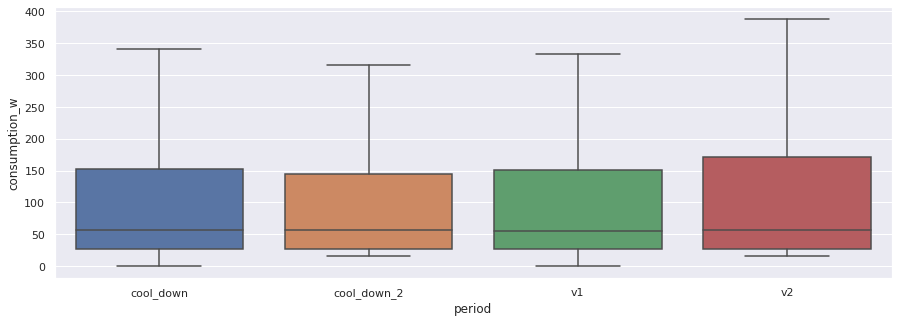

In [115]:
ax = sns.boxplot(x="period", y="consumption_w", data=vt_u.sort_values(by='period'),showfliers = False)

In [116]:
multi_u(vt_u[vt_u['user_usage']!="Casual"],'consumption_w','period')

v1 vs cool_down : MannwhitneyuResult(statistic=5057532.0, pvalue=0.00011884005302116203)
cool_down vs v2 : MannwhitneyuResult(statistic=5170510.0, pvalue=0.11521034828152638)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=4354351.0, pvalue=1.1077513186803619e-05)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=4709922.5, pvalue=0.3259402673757793)


In [117]:
multi_u(vt_u[vt_u['user_usage']=="Casual"],'consumption_w','period')

v1 vs cool_down : MannwhitneyuResult(statistic=42285.0, pvalue=0.47783490422684377)
cool_down vs v2 : MannwhitneyuResult(statistic=44216.5, pvalue=0.02953320821318997)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=29578.5, pvalue=0.02900450281250372)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=23316.0, pvalue=0.0003222087640581775)


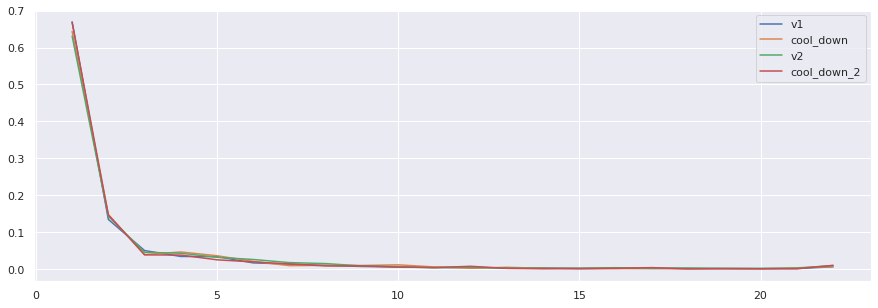

In [118]:
density_plot(vt_u)

## Đà Nẵng

In [119]:
multi_u(dna_u,'consumption_w','period')

v1 vs cool_down : MannwhitneyuResult(statistic=6075485.5, pvalue=0.09222627691632806)
cool_down vs v2 : MannwhitneyuResult(statistic=5554025.0, pvalue=0.11572926842220854)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=5353663.0, pvalue=0.3103601505573232)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=5648665.0, pvalue=0.001449629579133562)


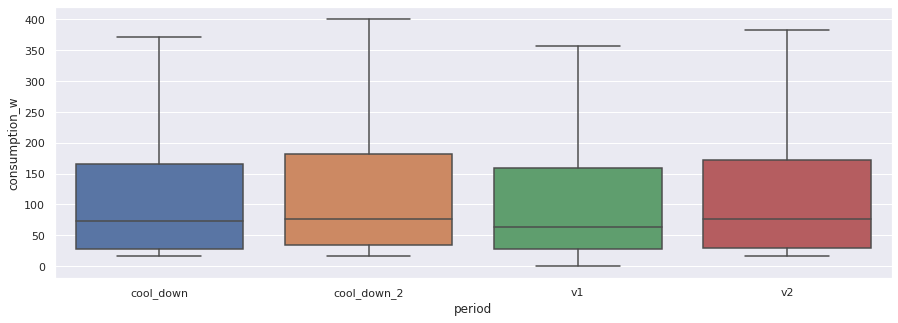

In [120]:
ax = sns.boxplot(x="period", y="consumption_w", data=dna_u.sort_values(by='period'),showfliers = False)

In [121]:
multi_u(dna_u[dna_u['user_usage']!="Casual"],'consumption_w','period')

v1 vs cool_down : MannwhitneyuResult(statistic=5438200.5, pvalue=0.04652138992027626)
cool_down vs v2 : MannwhitneyuResult(statistic=4890880.5, pvalue=0.06603988381699309)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=4805629.5, pvalue=0.373183550360904)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=5154598.5, pvalue=0.002683796448328776)


In [122]:
stat(dna_u,group = ['period'], measure = ['total_consumption'])

,median,q25,q75,q90,q10
period,,,,,
cool_down,72.540,166.34700,27.270,404.3858,19.089
cool_down_2,76.356,181.34925,34.742,458.1360,19.089
v1,62.721,159.66900,27.270,369.0890,19.089
v2,76.356,171.80100,29.997,445.4520,19.089


## Đồng Nai

In [123]:
multi_u(dn_u,'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=14355228.0, pvalue=0.49793301285112623)
cool_down vs v2 : MannwhitneyuResult(statistic=14544210.0, pvalue=0.0015387707992710734)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=12967169.0, pvalue=0.07473374609344115)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=12373531.0, pvalue=0.08738928903827625)


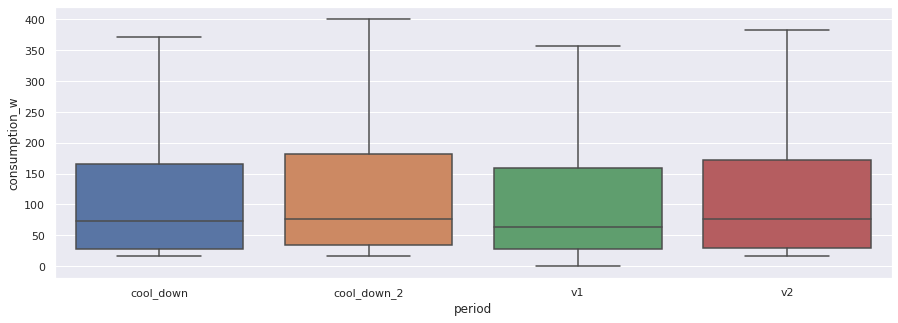

In [124]:
ax = sns.boxplot(x="period", y="consumption_w", data=dna_u.sort_values(by='period'),showfliers = False)

In [125]:
cent_stat(dn_u,group = ['period'], measure = ['total_consumption'])

,count,mean,median
period,,,
cool_down,3479,154.877552,54.540
cool_down_2,3049,162.539920,57.267
v1,8253,164.824214,57.267
v2,8657,177.493612,57.267


## Hải Phòng

In [126]:
multi_u(hp_u,'total_consumption','period')

v1 vs cool_down : MannwhitneyuResult(statistic=2747845.0, pvalue=0.014859109120434092)
cool_down vs v2 : MannwhitneyuResult(statistic=2534947.0, pvalue=0.3314265258210102)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=2397183.0, pvalue=0.03375202876846982)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=2769534.0, pvalue=0.4630740281123313)


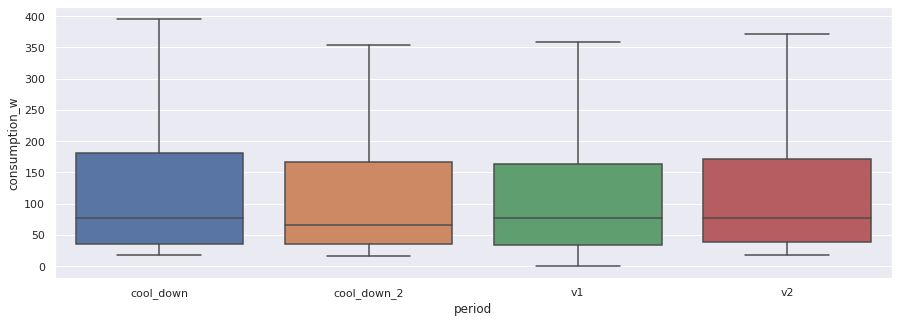

In [127]:
ax = sns.boxplot(x="period", y="consumption_w", data=hp_u.sort_values(by='period'),showfliers = False)

## Hòa Bình

In [128]:
multi_u(hb_u,'consumption_w','period')

v1 vs cool_down : MannwhitneyuResult(statistic=805216.5, pvalue=0.0029860836890224134)
cool_down vs v2 : MannwhitneyuResult(statistic=993759.5, pvalue=0.045355023038349485)
v2 vs cool_down_2 : MannwhitneyuResult(statistic=1138677.0, pvalue=0.45386899813848747)
cool_down_2 vs v1 : MannwhitneyuResult(statistic=848829.5, pvalue=1.467160120635992e-06)


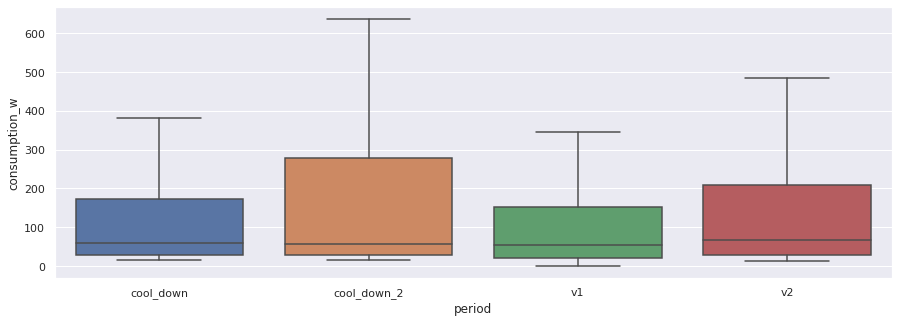

In [129]:
ax = sns.boxplot(x="period", y="consumption_w", data=hb_u.sort_values(by='period'),showfliers = False)

In [130]:
hb_u.groupby('period')['consumption_w'].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
cool_down,810.0,199.000683,351.198623,16.226,27.270,59.994,171.8010,2118.488
cool_down_2,894.0,253.036391,437.301912,16.417,27.270,57.267,278.5035,2118.488
v1,2127.0,170.633604,323.570101,0.000,21.816,54.540,152.7120,2118.488
v2,2554.0,229.600229,398.787476,14.180,27.270,67.956,209.9790,2118.488


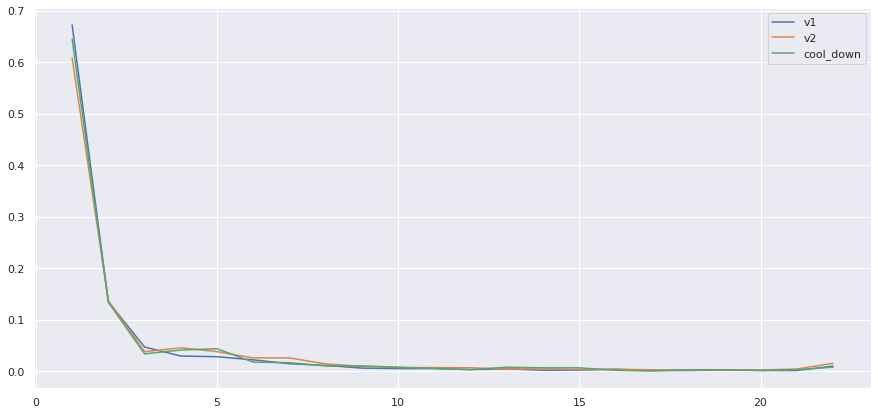

In [131]:
x1 = dens(hb_u['consumption_w'][hb_u['period']=='v1'], bin_range = 100)
xc = dens(hb_u['consumption_w'][hb_u['period']=='cool_down'], bin_range = 100)
x2 = dens(hb_u['consumption_w'][hb_u['period']=='v2'], bin_range = 100)

l = max(len(x1),len(x2),len(xc))
y = list(range(1, l+1))

sns.set(rc={'figure.figsize':(15,7)})
plt.plot(y, x1, label = 'v1')
plt.plot(y, x2, label = 'v2')
plt.plot(y, xc, label = 'cool_down')
plt.legend()
plt.show()